# Mini Project 1
## Mining Association rules using Apriori, Apriori with transaction reduction and FPGrowth algorithms

This study is to compare the computational performance of the 3 different methods of mining association rules by determining the run times for the Adult dataset from http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data. 

In [70]:
import pandas as pd
import numpy as np
from collections import defaultdict, namedtuple
from itertools import chain,combinations
import itertools
import time


#### Import data:
The dataset is imported to a pandas dataframe from which the transactions mining would be done.

In [ ]:
headers = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

In [4]:
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=headers, index_col=False)

In [34]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


The transactions from the dataframe is converted in a list of itemsets via the function below:

In [7]:
def gettransactionset(data):
    tranlist = []
    for i in data.index:
        itemset = []
        for k,v in dict(data.iloc[i]).items():
            if isinstance(v, str) or not np.isnan(v): #Handle missing values
                itemset.append(k + ' - ' + str(v))
        tranlist.append(frozenset(itemset))
    return tranlist


### 1: Apriori Algorithm

The apriori algorithm is implemented as stated below:

In [35]:
def frequent1itemset(transactions, minsup):
    '''
    transactions: list of transaction set
    minsup: absolute minimum support count
    
    returns list one itemsets as well as a dictionary one itemsets with support counts.
    '''
    count = len(transactions)
    oneitems = defaultdict(int)
    oneitemsupport = set()
    
    for transaction in transactions:
        for item in transaction:
            oneitems[item] += 1
            
    for k, v in oneitems.items():
        if v >= (minsup * count):
            oneitemsupport.add(frozenset([k]))
        #else:
        #    del oneitems[k]
            
    return oneitemsupport, oneitems

In [36]:
def selfjoin(prevfreqset, targetlength):
    '''
    This function performs a self joining to determine the K itemset
    prevfreqset: frequent K - 1 itemset
    targetlength: The K value i.e the length of the frequent items
    returns a set of items.
    '''
    #return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == targetlength])
    return set([i.union(j) for i in prevfreqset for j in prevfreqset if len(i.union(j)) == targetlength])

In [37]:
def hasinfrequentsubset(freqitems, previousL):
    '''
    ***Checks if any of the joined frequent items is infrequent.
    freqitems: an item set
    previousL: previous list of frequent itemset.
    returns a boolean value corresponding if the itemset has infrequent subset
    
    '''
    for i in freqitems:
        #seti = set([i])
        if previousL.issuperset([i]):
            return False
    return True

In [38]:
def getfrequentitemsfromL(L, transactions, minsupport):
    '''
    Scans transactions to determine itemsets which are frequent.
    L: List of frequent itemsets
    transactions: list of transactions
    minsupport: absolute minimum support
    
    returns set of frequent itemsets as well as a dictionary frequent items and a support count.
    '''
    
    freqitems = set()
    #itemcounts = set()
    itemcount = defaultdict(int)
    for i in L:
        #itemcount = defaultdict(int)
        for itemset in transactions:
            if i.issubset(itemset):
                itemcount[i] += 1
        if itemcount[i] / len(transactions) >= minsupport:
            freqitems.add(i)
        #else:
        #    del itemcount[i]
    
    return freqitems, itemcount

In [65]:
def generatefrequentitemsApriori(transactions, minsupport):
    '''
    Runs full process to get all frequent itemsets.
    transactions: full list of all transactions
    minsupport: absolute minimum support
    
    returns a set of frequent itemsets and set of dictionary of frequent itemset and each support count.
    '''
    
    starttime = time.time()
    #Get frequent 1-Item sets
    K = 1
    #L1 = frequent1itemset(transactions, minsupport)
    Fulllist = set([])
    CurrentSet, Fulldict = frequent1itemset(transactions, minsupport)
    Lkprev = set()
    K += 1
    while CurrentSet != set([]):
        #print('Loop %i, %i'%(K, len(Fulllist)))
        Lkprev.union(CurrentSet)
        CurrentSet = selfjoin(CurrentSet, K)
    #Using Apriori rule
        inf = set()
        for i in CurrentSet:
            if hasinfrequentsubset(i, Lkprev):
                inf.add(i)
        CurrentSet.discard(inf)
    #Scan transaction list for minimum support
        CurrentSet, CurrentD = getfrequentitemsfromL(CurrentSet, transactions, minsupport)
        Fulllist = Fulllist.union(CurrentSet)
        Fulldict.update(CurrentD)
        K += 1
        
    return Fulllist, Fulldict, time.time() - starttime

In [13]:
def subsets(myset):
    """ Returns non empty subsets of arr"""
    cs = chain(*[combinations(myset, i + 1) for i, a in enumerate(myset)])
    return map(frozenset, [x for x in cs])

In [14]:
def getffrequentassociations(frequentset, frequentsetcounters, minconf, numoftrans):
    '''
    frequentset: Set of frequent items from which rules are to be obtained.
    frequentsetcounters: Set of frequent items with their support count.
    minconf: minumum confidence which must hold for a rule to be frequent.
    numoftrans: number of transactions which is being mined.
    '''
    def getsupport(item):
        '''
        item: Item in frequent itemset whose minimums support is to be determined.
        Returns float value of support value.
        '''
        if len(item) == 1:
            item = list(item)[0]
        return float(frequentsetcounters[item])/numoftrans
    
    frequentrules = []
    for freqitem in frequentset:
        #Get Subsets for frequent item
        subs = subsets(freqitem)
        for element in subs:
            rem = freqitem.difference(element)
            if len(rem) > 0:
                conf = getsupport(freqitem)/getsupport(element)
                if conf >= minconf:
                    frequentrules.append(((tuple(element), tuple(rem)), conf, getsupport(freqitem)))
                    
    #return sorted(frequentrules, reverse=True, key = lambda rule, conf, sup: sup)
    return frequentrules

In [42]:
-

In [16]:
associationruleminer(data, 0.8, 0.6)

Rule 0: ('capital-loss - 0',) => ('native-country -  United-States',) - support: 0.85, confidence: 0.90
Rule 1: ('native-country -  United-States',) => ('capital-loss - 0',) - support: 0.85, confidence: 0.95
Rule 2: ('capital-gain - 0',) => ('native-country -  United-States',) - support: 0.82, confidence: 0.89
Rule 3: ('native-country -  United-States',) => ('capital-gain - 0',) - support: 0.82, confidence: 0.92
Rule 4: ('capital-gain - 0',) => ('capital-loss - 0',) - support: 0.87, confidence: 0.95
Rule 5: ('capital-loss - 0',) => ('capital-gain - 0',) - support: 0.87, confidence: 0.91
Rule 6: ('capital-loss - 0',) => ('race -  White',) - support: 0.81, confidence: 0.85
Rule 7: ('race -  White',) => ('capital-loss - 0',) - support: 0.81, confidence: 0.95
--- 11.927528381347656 seconds ---


In [17]:
#itemset, itemsetsupport = generatefrequentitemsApriori(set, 0.5)

### 2: Apriori Algorithm with transaction Reduction

This implements the apriori algorithm but the transaction list reduced with each pass. 
This is based on the principle that the transaction list for which there is no frequent K itemset cannot have a K + 1 itemset.

In [75]:
#Implement improvement to the apriori algorithm

## Using transaction reduction

def getfrequentitemsTranReduction(L, transactions, minsupport, numberoftrans):
    
    '''
    Scans transactions to determine itemsets which are frequent.
    L: List of frequent itemsets
    transactions: list of transactions
    minsupport: absolute minimum support
    numberoftrans: Number of transactions in the transaction set.
    
    returns set of frequent itemsets as well as a dictionary frequent items and a support count.
    '''
    freqitems = set()
    #itemcounts = set()
    itemcount = defaultdict(int)
    tranindex =  defaultdict(int)
    for i in L:
        #itemcount = defaultdict(int)
        for cnt, itemset in enumerate(transactions):
            if i.issubset(itemset):
                itemcount[i] += 1
                tranindex[cnt] += 1  #To facilitate transaction reduction
        if itemcount[i] / numberoftrans >= minsupport:
            freqitems.add(i)
        
    
    #********Reduce transaction side by deleting unreferenced transactions
    
    trans = list(transactions)
    for i in range(len(transactions)):
        if i not in tranindex.keys():
            transactions.remove(trans[i])
    #print('Current Length %d' % len(transactions))
    return freqitems, itemcount, transactions


def generatefrequentitemsAprioriWithReduction(transactions, minsupport, numberoftrans):
    '''
    Runs full process to get all frequent itemsets.
    transactions: full list of all transactions
    minsupport: absolute minimum support
    numberoftrans: number of transaction.
    
    returns a set of frequent itemsets and set of dictionary of frequent itemset and each support count.
    '''
    starttime = time.time()
    #Get frequent 1-Item sets
    K = 1
    #L1 = frequent1itemset(transactions, minsupport)
    Fulllist = set([])
    CurrentSet, Fulldict = frequent1itemset(transactions, minsupport)
    Lkprev = set()
    K += 1
    while CurrentSet != set([]):
        #print('Loop %i, %i'%(K, len(Fulllist)))
        Lkprev.union(CurrentSet)
        CurrentSet = selfjoin(CurrentSet, K)
    #Using Apriori rule
        inf = set()
        for i in CurrentSet:
            if hasinfrequentsubset(i, Lkprev):
                inf.add(i)
        CurrentSet.discard(inf)
    #Scan transaction list for minimum support
        CurrentSet, CurrentD, transactions = getfrequentitemsTranReduction(CurrentSet, transactions, minsupport, numberoftrans)
        Fulllist = Fulllist.union(CurrentSet)
        Fulldict.update(CurrentD)
        K += 1
        
    return Fulllist, Fulldict, time.time() - starttime

In [32]:

def associationruleminerWithReduction(transaction, minsup, minconf):
    '''
    transaction: The list of transactions to be mined in pandas dataframe
    minsupport: The absolute minimum support
    minconf: The absolute value of the minimum confidence
    
    returns the time for running.
    '''
    
    import time
    start_time = time.time()
    
    #Convert transaction dataframe into a set of items.
    transactions = gettransactionset(transaction)
    
    n  = len(transactions)
    #Get frequent itemsets and itemset support count
    itemset, itemsetsupport, t = generatefrequentitemsAprioriWithReduction(transactions, minsup, numberoftrans=n)
    
    #Mine association rules from frequent itemsets
    assocrules = getffrequentassociations(itemset, itemsetsupport, minconf=minconf, numoftrans=n)
    
    #print out association rules
    
    for i, rule in enumerate(assocrules):
        print('Rule %i: %s => %s - support: %0.2f, confidence: %0.2f' %(i, rule[0][0], rule[0][1], rule[2], rule[1]))
        
    return (time.time() - start_time)

In [20]:
## Sample run with 0.8 minimum support and 0.6 minimum confidence
associationruleminerWithReduction(data, 0.8, 0.6)

--- 11.400942087173462 seconds ---


Current Length 32411
Current Length 29536
Rule 0: ('capital-loss - 0',) => ('native-country -  United-States',) - support: 0.85, confidence: 0.90
Rule 1: ('native-country -  United-States',) => ('capital-loss - 0',) - support: 0.85, confidence: 0.95
Rule 2: ('capital-gain - 0',) => ('native-country -  United-States',) - support: 0.82, confidence: 0.89
Rule 3: ('native-country -  United-States',) => ('capital-gain - 0',) - support: 0.82, confidence: 0.92
Rule 4: ('capital-gain - 0',) => ('capital-loss - 0',) - support: 0.87, confidence: 0.95
Rule 5: ('capital-loss - 0',) => ('capital-gain - 0',) - support: 0.87, confidence: 0.91
Rule 6: ('capital-loss - 0',) => ('race -  White',) - support: 0.81, confidence: 0.85
Rule 7: ('race -  White',) => ('capital-loss - 0',) - support: 0.81, confidence: 0.95
--- 15.136366367340088 seconds ---


### 3: FP-Growth Algorithm

Implement the FP-Growth algorithm by building and mining the FP as done below.

In [62]:
-

## Testing  the different Algorithms

We would test 3 algorithms using minimum supports of 0.8, 0.75, 0.7, 0.65, 0.6

In [68]:
minsupport = [0.8, 0.75, 0.7, 0.65, 0.6]
FPgrowth = {}
Apriori = {}
Aprioriwithreduction = {}


In [77]:
for i in minsupport:
    a,b,t = generatefrequentitemsApriori(gettransactionset(data), i)
    FPgrowth[i] = t
    a,b,t = find_frequent_patterns(gettransactionset(data), i)
    Apriori[i] = t
    a, b, t = generatefrequentitemsAprioriWithReduction(gettransactionset(data), i, len(gettransactionset(data)))
    Aprioriwithreduction[i] = t

In [78]:
FPgrowth

{0.6: 0.47531962394714355,
 0.65: 0.390277624130249,
 0.7: 0.22517609596252441,
 0.75: 0.19615793228149414,
 0.8: 0.19113373756408691}

In [79]:
Apriori

{0.6: 1.3680055141448975,
 0.65: 1.212876558303833,
 0.7: 0.9776928424835205,
 0.75: 0.8966350555419922,
 0.8: 0.7075178623199463}

In [80]:
Aprioriwithreduction

{0.6: 12.861106157302856,
 0.65: 14.183064222335815,
 0.7: 14.223069906234741,
 0.75: 3.039151430130005,
 0.8: 4.699326992034912}

In [81]:
import matplotlib.pyplot as plt

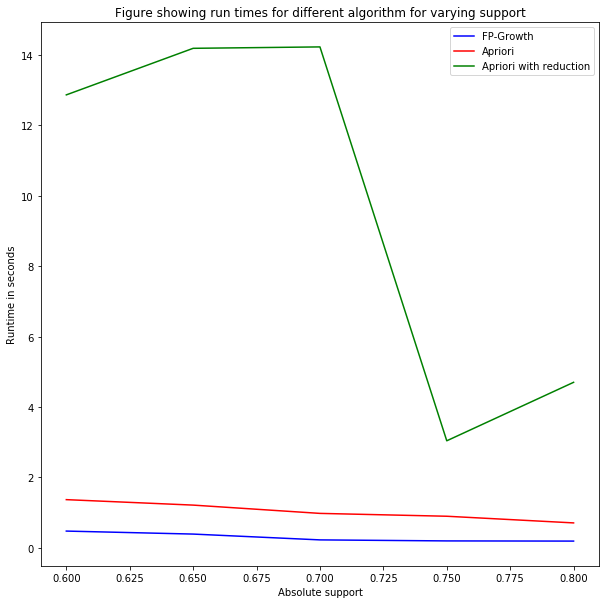

In [87]:
plt.figure(figsize=[10,10])
plt.plot(list(FPgrowth.keys()), list(FPgrowth.values()), color = 'blue', label = 'FP-Growth')
plt.plot(list(Apriori.keys()), list(Apriori.values()), color = 'red', label = 'Apriori')
plt.plot(list(Aprioriwithreduction.keys()), list(Aprioriwithreduction.values()), color = 'green', label = 'Apriori with reduction')
plt.ylabel('Runtime in seconds')
plt.xlabel('Absolute support')
plt.legend()
plt.title('Figure showing run times for different algorithm for varying support')
plt.show()

We can conclude that FP-Growth algorithm has the best performance for the given dataset. Although transaction reduction was meant to be an improvement to the Apriori algorithm, it shows a deterioration in performance largely due to cost of reducing the size for each iteration and due to the distribution of the attributes. The improvement should be felt for larger datasets.

## The End